In [1]:
## Downgrade matplotlib to fix a compatibility issue

# !pip install --upgrade --user matplotlib==3.7.3 ydata_profiling google.cloud.bigquery google.cloud.aiplatform

In [2]:
import json
import os
from typing import Union

import google.cloud.aiplatform as vertex_ai
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot

%matplotlib inline

## Data Loading

The original csv text files were uploaed on to GCS bucket then loaded into Bigquery tables:
- blackfridayintelia.blackfriday.blackfriday for the training data
- blackfridayintelia.blackfriday.blackfriday_test for the test data


In [3]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

In [4]:
%%bigquery df_blackfriday_test_data
select * from `blackfridayintelia.blackfriday.blackfriday_test`

In [5]:
# %store -r df_blackfriday_data df_blackfriday_test_data

## Business Requirement Analysis
The first step is to understand what we are trying to achieve. By comparing the training and test sets, we found that all users and products in the test set are also in the training set. This means that the task is to use users' past purchases to predict how much other products they are likely to buy. This suggests that our solution should be a recommendation system rather than a regular regression model. This has a significant impact on the features we select and the process of how we prepare the data.

### All users in the test set are also in the train set

In [6]:

df_blackfriday_test_data[~df_blackfriday_test_data.User_ID.isin(df_blackfriday_data.User_ID.unique())].shape

(0, 11)

### The test data is about predict purchase on new products. 

In [7]:
pd.merge(df_blackfriday_test_data[['User_ID', 'Product_ID']], 
         df_blackfriday_data[['User_ID', 'Product_ID', 'Purchase']], 
         on=['User_ID', 'Product_ID'], 
         how='inner').shape

(0, 3)

## Data Profiling

In [9]:
df_blackfriday_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [10]:
print(f'Number of unique users: {df_blackfriday_data.User_ID.nunique()}')
print(f'Number of unique products: {df_blackfriday_data.Product_ID.nunique()}')

Number of unique users: 5891
Number of unique products: 3631


In [11]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_blackfriday_data, title='BlackFriday Profile',  minimal=False)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
dfaa = df_blackfriday_data.groupby(['Product_Category_1','Product_Category_2','Product_Category_3']).count().reset_index()
dfaa

Product_Category_1  Product_Category_2  Product_Category_3  User_ID  \
0                     1                 2.0                 3.0      613   
1                     1                 2.0                 4.0      524   
2                     1                 2.0                 5.0     7982   
3                     1                 2.0                 6.0     1924   
4                     1                 2.0                 8.0     2800   
..                  ...                 ...                 ...      ...   
132                  11                15.0                16.0      850   
133                  12                14.0                17.0      159   
134                  13                14.0                16.0      519   
135                  13                15.0                16.0      537   
136                  15                16.0                17.0      151   

     Product_ID  Gender   Age  Occupation  City_Category  \
0           613     613   613         613            613   
1           524     524   524         524            524   
2          7982    7982  7982        7982           7982   
3          1924    1924  1924        1924           1924   
4          2800    2800  2800        2800           2800   
..          ...     ...   ...         ...            ...   
132         850     850   850         850            850   
133         159     159   159         159            159   
134         519     519   519         519            519   
135         537     537   537         537            537   
136         151     151   151         151            151   

     Stay_In_Current_City_Years  Marital_Status  Purchase  
0                           613             613       613  
1                           524             524       524  
2                          7982            7982      7982  
3                          1924            1924      1924  
4                          2800            2800      2800  
..                          ...             ...       ...  
132                         850             850       850  
133                         159             159       159  
134                         519             519       519  
135                         537             537       537  
136                         151             151       151  

[137 rows x 12 columns]

### There is a strange pattern that Product_Category_1 is always greater than Product_Category_2, and Product_Category_2 is always greater than Product_Category_3

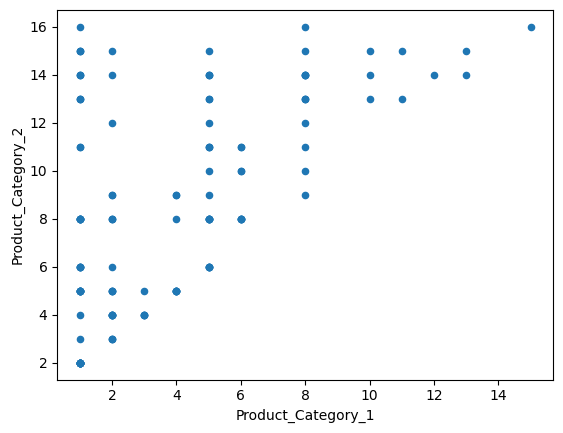

In [13]:
dfaa.plot.scatter(x='Product_Category_1', y='Product_Category_2')
plt.show()

<Axes: xlabel='Product_Category_2', ylabel='Product_Category_3'>

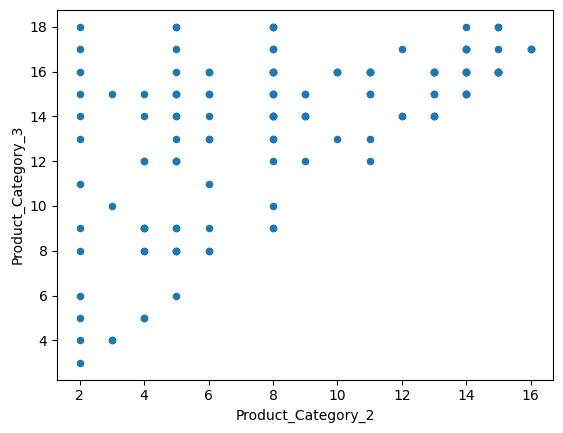

In [14]:
dfaa.plot.scatter(x='Product_Category_2', y='Product_Category_3')

### Purchase column is slightly right skewed

We are going to perform the following data transformation:
1. Square Root transformation to reduce the skewness and kurtosis problem
2. minus 3.464 and then divide by 15 to shrink the values into the range of [0, 10.0]. This is necessary because some of the downstream recommendation models only accept values in that range. 

In [15]:
print("Skewness:", df_blackfriday_data['Purchase'].skew())
print("Kurtosis:", df_blackfriday_data['Purchase'].kurtosis())
df_blackfriday_data['Purchase'].describe()

Skewness: 0.6001400037087128
Kurtosis: -0.3383775655851702


count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [16]:
print("Skewness sqrt:", df_blackfriday_data['Purchase'].pow(1/2).skew())
print("Kurtosis sqrt:", df_blackfriday_data['Purchase'].pow(1/2).kurtosis())
((df_blackfriday_data['Purchase'].pow(1/2)-3.464)/15).describe()

Skewness sqrt: -0.13958796269869106
Kurtosis sqrt: -0.10368674410146506


count    550068.000000
mean          5.924095
std           1.813511
min           0.000007
25%           4.856306
50%           5.749405
75%           7.088447
max          10.088627
Name: Purchase, dtype: float64

<Axes: ylabel='Density'>

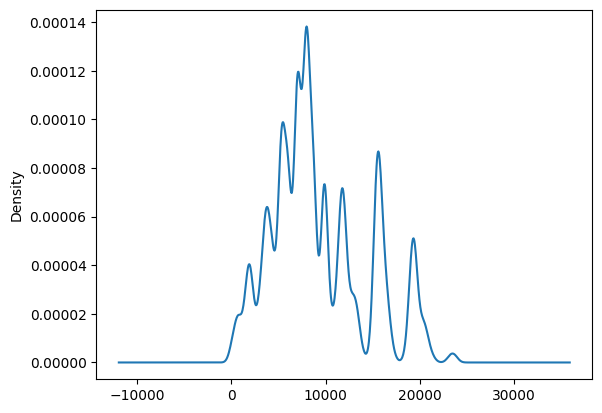

In [17]:
df_blackfriday_data['Purchase'].plot.density()

<Axes: ylabel='Density'>

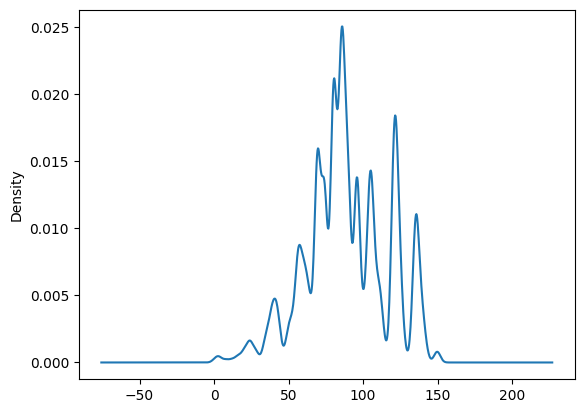

In [18]:
(df_blackfriday_data['Purchase'].pow(1/2)-3.464).plot.density()

### Users purchase different types of products under the same product category

Most users don't purchase many different types of same category products, however, some users purchase more than 20 types of same category products.

In [19]:
dfbb = df_blackfriday_data.groupby(['User_ID','Product_Category_1','Product_Category_2','Product_Category_3'])['Purchase'].agg(['min', 'max', 'count', 'mean', 'std']).reset_index()

<Axes: >

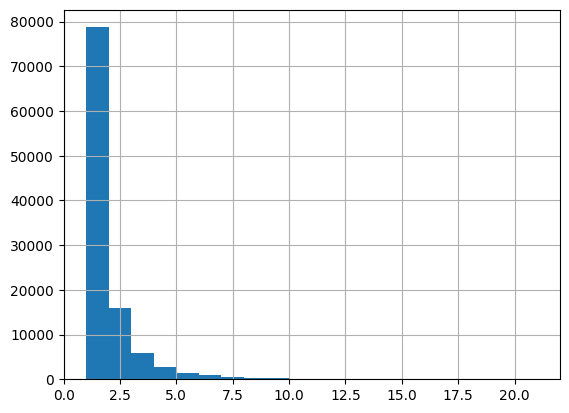

In [20]:
dfbb['count'].hist(bins=20)

<Axes: ylabel='Density'>

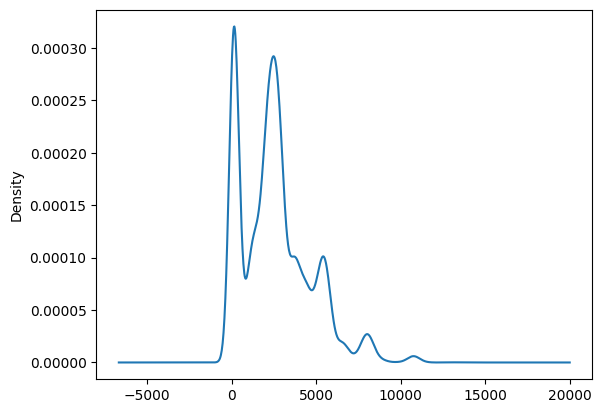

In [21]:
dfbb['std'].plot.density()

In [22]:
dfbb[dfbb['std']>1000]

User_ID  Product_Category_1  Product_Category_2  Product_Category_3  \
5       1000001                   3                 4.0                 5.0   
6       1000001                   3                 4.0                12.0   
14      1000002                   1                 2.0                16.0   
19      1000002                   1                 8.0                17.0   
31      1000003                   1                 2.0                 5.0   
...         ...                 ...                 ...                 ...   
107229  1006040                   1                 2.0                 8.0   
107232  1006040                   1                 2.0                15.0   
107233  1006040                   1                 6.0                14.0   
107239  1006040                   1                15.0                16.0   
107245  1006040                   6                 8.0                10.0   

          min    max  count          mean           std  
5       10900  13650      2  12275.000000   1944.543648  
6        8190  13645      5  11417.000000   2297.258910  
14      11749  15781      2  13765.000000   2851.054542  
19       8266  19465      2  13865.500000   7918.888843  
31       3938  19327      2  11632.500000  10881.666256  
...       ...    ...    ...           ...           ...  
107229   4315  11860      2   8087.500000   5335.120664  
107232   8288  15694      3  11965.666667   3703.259960  
107233  12031  15638      2  13834.500000   2550.534160  
107239  11601  15630      3  12974.000000   2300.603616  
107245  16110  20317      2  18213.500000   2974.798228  

[21385 rows x 9 columns]

In [23]:
df_blackfriday_data[(df_blackfriday_data.User_ID==1006036) 
                    & (df_blackfriday_data.Product_Category_1 == 1)
                    & (df_blackfriday_data.Product_Category_2 == 2)
                    & (df_blackfriday_data.Product_Category_3 == 15)]

User_ID Product_ID Gender    Age  Occupation City_Category  \
39139   1006036  P00243942      F  26-35          15             B   
39151   1006036  P00079742      F  26-35          15             B   
194533  1006036  P00244242      F  26-35          15             B   
233693  1006036  P00127442      F  26-35          15             B   
233695  1006036  P00173842      F  26-35          15             B   
272758  1006036  P00105142      F  26-35          15             B   
272775  1006036  P00244042      F  26-35          15             B   
350769  1006036  P00191442      F  26-35          15             B   
428846  1006036  P00105342      F  26-35          15             B   
428853  1006036  P00127842      F  26-35          15             B   
428860  1006036  P00032042      F  26-35          15             B   
467617  1006036  P00046742      F  26-35          15             B   
545887  1006036  P00127742      F  26-35          15             B   
545890  1006036  P00244142      F  26-35          15             B   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
39139                          4+               1                   1   
39151                          4+               1                   1   
194533                         4+               1                   1   
233693                         4+               1                   1   
233695                         4+               1                   1   
272758                         4+               1                   1   
272775                         4+               1                   1   
350769                         4+               1                   1   
428846                         4+               1                   1   
428853                         4+               1                   1   
428860                         4+               1                   1   
467617                         4+               1                   1   
545887                         4+               1                   1   
545890                         4+               1                   1   

        Product_Category_2  Product_Category_3  Purchase  
39139                  2.0                15.0      7641  
39151                  2.0                15.0      7948  
194533                 2.0                15.0      4279  
233693                 2.0                15.0      8272  
233695                 2.0                15.0      8044  
272758                 2.0                15.0     15462  
272775                 2.0                15.0      7848  
350769                 2.0                15.0     12011  
428846                 2.0                15.0     11925  
428853                 2.0                15.0      8090  
428860                 2.0                15.0     11699  
467617                 2.0                15.0     11544  
545887                 2.0                15.0     11398  
545890                 2.0                15.0      7846

### Users purchase different amount of products 

<Axes: >

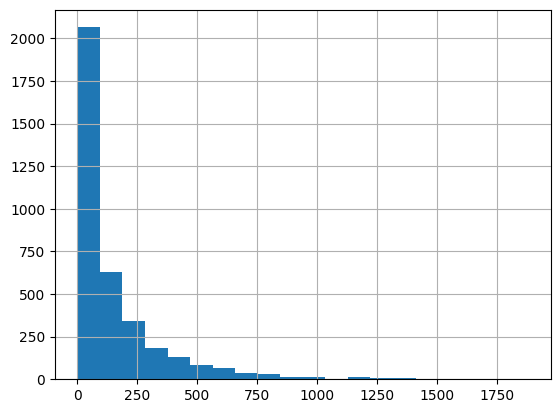

In [24]:
dfcc = df_blackfriday_data.groupby(['Product_ID'])['Purchase'].agg(['min', 'max', 'count', 'mean', 'std']).reset_index()
dfcc['count'].hist(bins=20)

<Axes: >

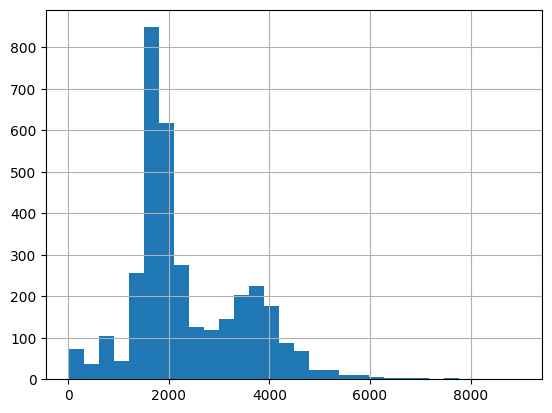

In [25]:
dfcc['std'].hist(bins=30)

### Dispite the imbalanced categories, there's no significant purchasing behaviour differences between categories.

Total purchase for group Gender:



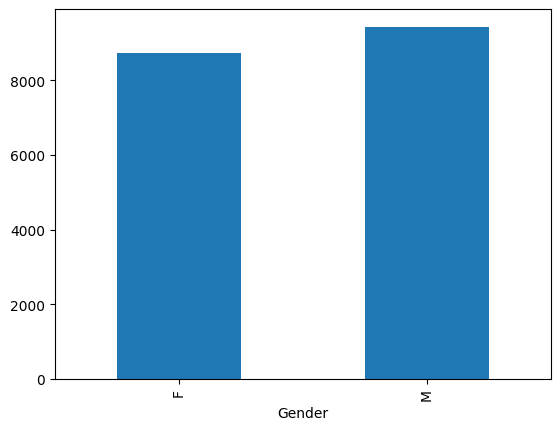

Total purchase for group Age:



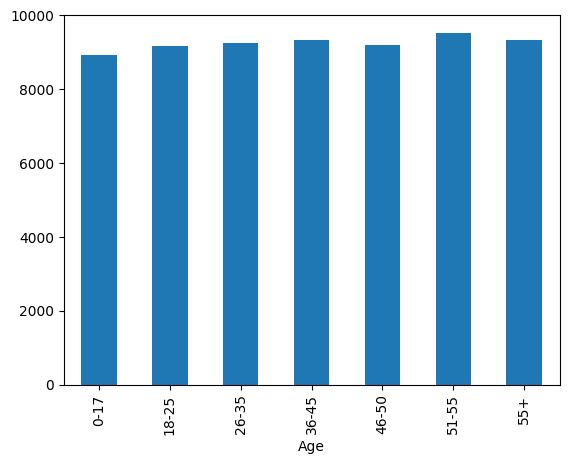

Total purchase for group Occupation:



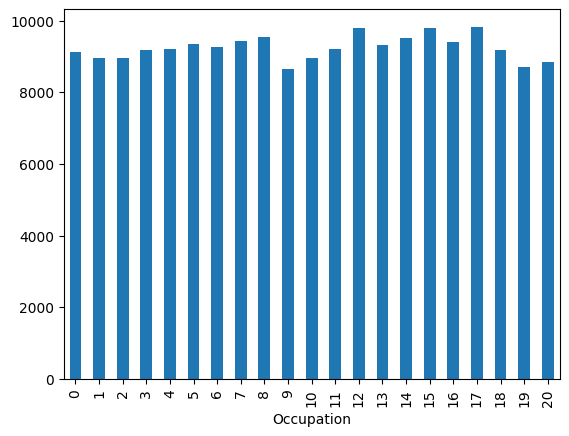

Total purchase for group City_Category:



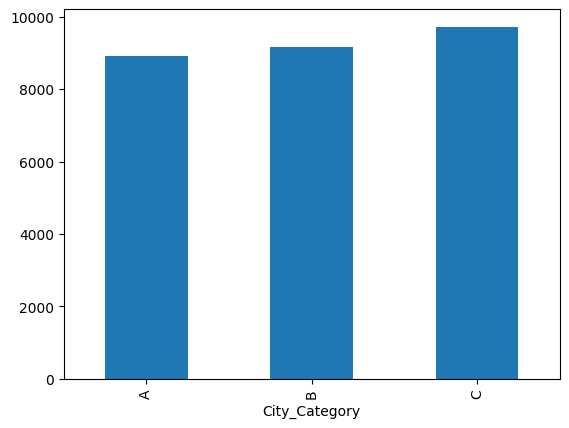

Total purchase for group Stay_In_Current_City_Years:



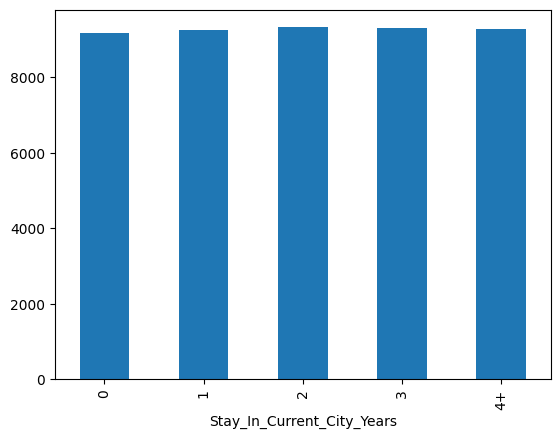

Total purchase for group Marital_Status:



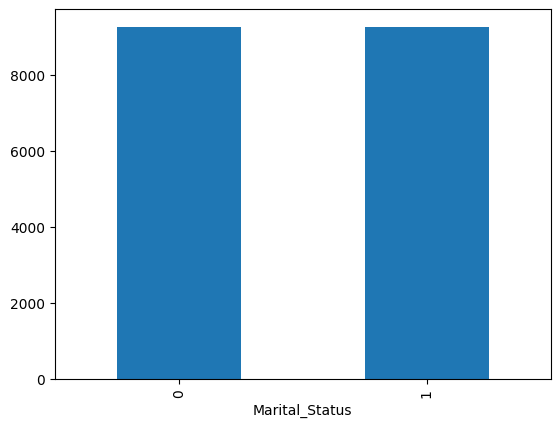

In [26]:
for x in ['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status']:
    print(f'Total purchase for group {x}:\n')
    df_blackfriday_data.groupby(x)['Purchase'].mean().plot.bar()
    plt.show()

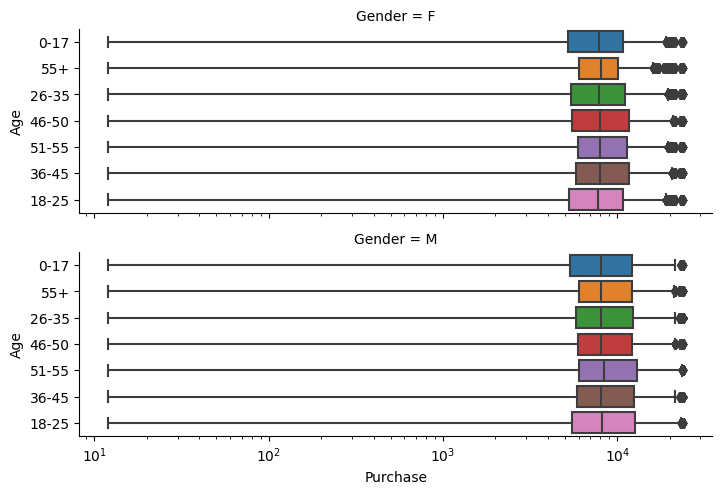

In [27]:
# Boxplot of Age Vs Purchase in horizontal orientation across Gender
g = sns.catplot(x="Purchase", y="Age", row="Gender",
                kind="box", orient="h", height=2.5, aspect=3,
                data=df_blackfriday_data)
g.set(xscale="log")

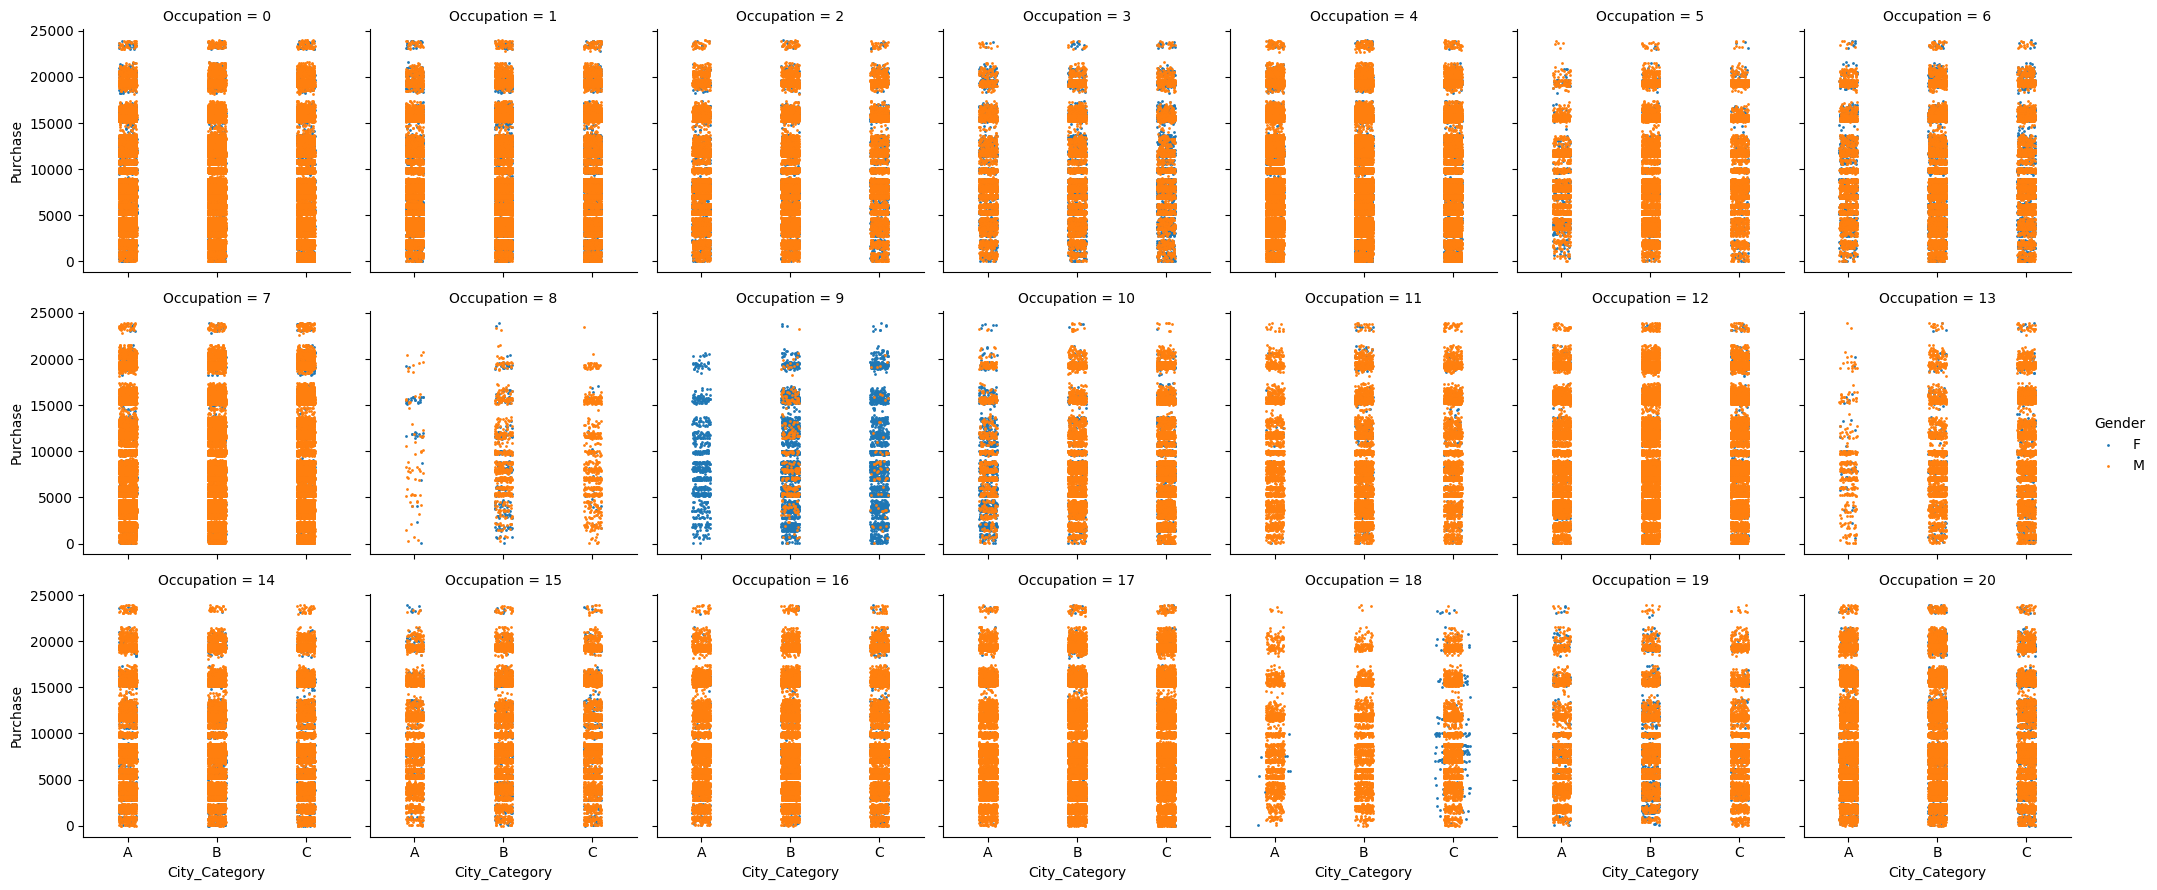

In [28]:
#Facetgrid for Occupation  + Purchase + City_Category  & hue = Gender
cond_plot = sns.FacetGrid(data=df_blackfriday_data, col='Occupation', hue='Gender', col_wrap=7)
cond_plot.map(sns.stripplot, 'City_Category', 'Purchase', order=['A', 'B', 'C'], size=2)
cond_plot.add_legend()

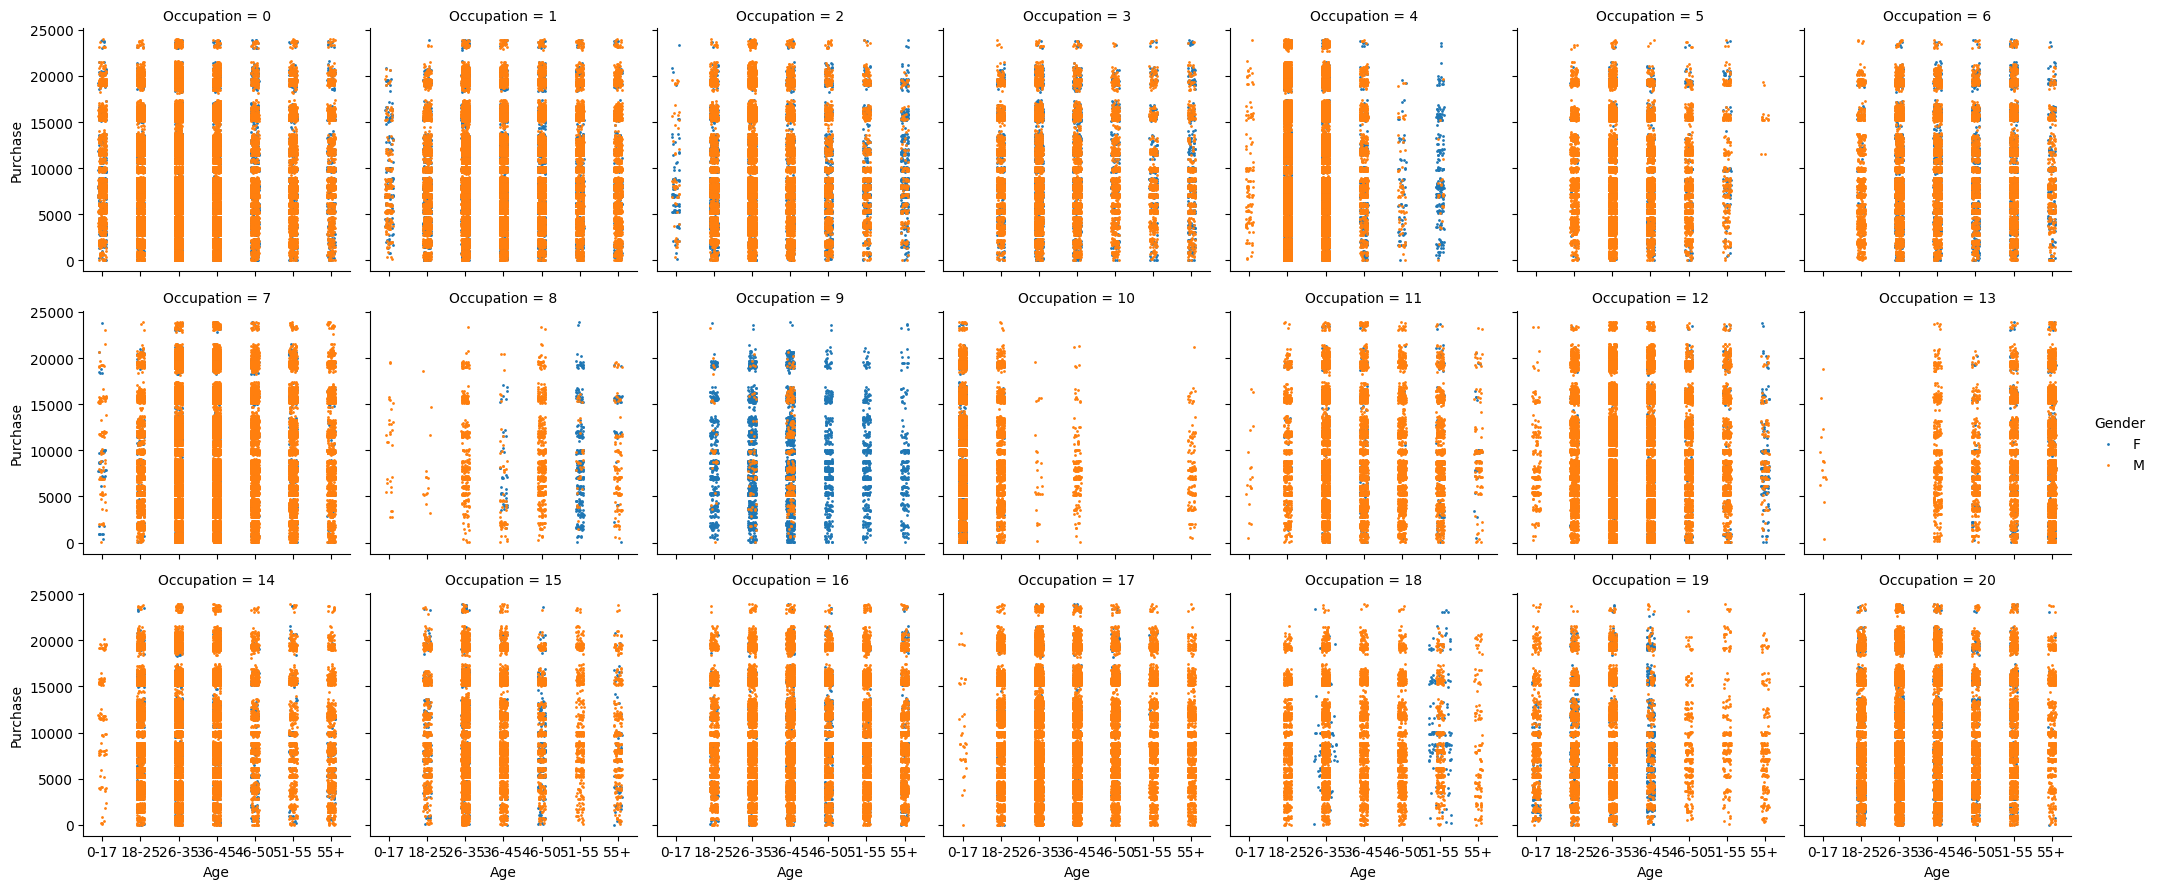

In [29]:
#Facetgrid for Occupation  + Purchase + City_Category  & hue = Gender
cond_plot = sns.FacetGrid(data=df_blackfriday_data, col='Occupation', hue='Gender', col_wrap=7)
cond_plot.map(sns.stripplot,  'Age', 'Purchase', order=['0-17', '18-25', '26-35', '36-45',  '46-50', '51-55', '55+'], size=2)
cond_plot.add_legend()